In [1]:
%matplotlib inline

import json
import math

import numpy
import matplotlib.pyplot as plot
import pandas

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.grid_search import GridSearchCV

In [2]:
corpuses = {
    'english_reviews':['pos_reviews.json','neg_reviews.json'],
    'russian_books': ['pos_russian_reviews_books.json','neg_russian_reviews_books.json'],
    'russian_films': ['pos_russian_reviews_films.json','neg_russian_reviews_films.json'],
    'russian_cameras': ['pos_russian_reviews_cameras.json','neg_russian_reviews_cameras.json'],
}

def mean_length(texts):
    return sum(len(text) for text in texts)/len(texts)

def get_all_texts_and_target(corpus, text_count_for_class):
    file_names = corpuses[corpus]
    with open(file_names[0]) as data_file:    
        data_pos = json.load(data_file)
    with open(file_names[1]) as data_file:    
        data_neg = json.load(data_file)

    pos_texts = data_pos.keys()[:text_count_for_class]
    neg_texts = data_neg.keys()[:text_count_for_class]
    all_texts = pos_texts + neg_texts
    N_POS_TEXTS = len(pos_texts)
    N_NEG_TEXTS = len(neg_texts)
    target = [1]*N_POS_TEXTS + [0]*N_NEG_TEXTS
    
    print "Позитивных текстов: " + str(N_POS_TEXTS)
    print "Негативных текстов: " + str(N_NEG_TEXTS)

    print "Средняя длина позитивных текстов: " + str(mean_length(pos_texts))
    print "Средняя длина негативных текстов: " + str(mean_length(neg_texts))
    
    return all_texts, target

In [3]:
all_texts, target = get_all_texts_and_target(corpus='english_reviews', text_count_for_class=1500)

Позитивных текстов: 1000
Негативных текстов: 1000
Средняя длина позитивных текстов: 4091
Средняя длина негативных текстов: 3629


In [4]:
def f1_measure(P,R):
    return [2*x*y/(x+y) for x,y in zip(P, R)]

In [5]:
def cross_valid(matrix_counts, target, test_size=0.3, random_state=0):
    X_train, X_test, Y_train, Y_test = train_test_split(matrix_counts, target, test_size=0.3, random_state=0)
    return (X_train, X_test, Y_train, Y_test)

In [15]:
def rp_curve(Y_test, predicted, label='?'):
    precision, recall, _ = metrics.precision_recall_curve(Y_test, predicted[:,1])
    plot.plot(recall, precision, label=label);
    plot.xlabel('Recall'); plot.ylabel('Precision'); 
    plot.legend(loc=0); plot.xlim([0.0, 1.0]); plot.ylim([0.0, 1])
    
def f1_curve(Y_test, predicted, label='?'):
    precision, recall, _ = metrics.precision_recall_curve(Y_test, predicted[:,1])
    plot.plot(recall, f1_measure(precision, recall), label=label)
    plot.xlabel('Recall'); plot.ylabel('F1-measure'); 
    plot.legend(loc=0); plot.xlim([0.0, 1.0]); plot.ylim([0.0, 1])

def roc_curve(Y_test, predicted, label='?'):
    fpr, tpr, th = metrics.roc_curve(Y_test, predicted[:,1])
    plot.plot(fpr, tpr, label=label);
    plot.xlabel('False Positive'); plot.ylabel('True Positive'); 
    plot.legend(loc=0); plot.xlim([0.0, 1.0]); plot.ylim([0.0, 1]);
    print '(', label, ') AUC = ', metrics.auc(fpr, tpr)

from sklearn.metrics import accuracy_score
def get_accuracy(Y_test, predicted):
    new_predicted = [1 if list[0] < list[1] else 0 for list in predicted]
    return accuracy_score(Y_test, new_predicted)

def get_auc(Y_test, predicted):
    fpr, tpr, _ = metrics.roc_curve(Y_test, predicted[:,1])
    return metrics.auc(fpr, tpr)

In [7]:
def report_cross_validation(grid_searcher, X_test, Y_test):
    print 'train score is {:.5f}'.format(grid_searcher.best_score_)
    print 'test score is {:.5f}'.format(grid_searcher.score(X_test, Y_test))
    print 'best parameter set:'
    for k in sorted(grid_searcher.best_params_):
        print ' * {}={}'.format(k, grid_searcher.best_params_[k])

In [8]:
def report_cross_validation_all_texts(grid_searcher):
    print 'train score is {:.5f}'.format(grid_searcher.best_score_)
    print 'best parameter set:'
    for k in sorted(grid_searcher.best_params_):
        print ' * {}={}'.format(k, grid_searcher.best_params_[k])

In [9]:
def logistic_reg(X_train, X_test, Y_train, **kwargs):
    model_logistic = LogisticRegression(**kwargs)
    model_logistic.fit(X_train, Y_train)
    predicted = model_logistic.predict_proba(X_test)
    return predicted, model_logistic

In [10]:
count_vect = CountVectorizer()
temp_matrix = count_vect.fit_transform(all_texts) # temp_matrix for calc tf-idf
matrix_counts = temp_matrix.toarray()

N_FEATURES = matrix_counts.shape[1]
words_as_features = {count_vect.vocabulary_.get(x):x for x in count_vect.vocabulary_}

# Код для прогонки всех методов

In [10]:
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import string
import pymorphy2
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy
import math

def log_f(x):
    return math.log(x+1)

russian_stemmer = SnowballStemmer("russian")
english_stemmer = PorterStemmer()
morph = pymorphy2.MorphAnalyzer()

english_stop_words = stopwords.words('english')
russian_stop_words = stopwords.words('russian')

def tokenize_english(text):
    tokens = word_tokenize(text)
    stems = [english_stemmer.stem(i) for i in tokens if i not in string.punctuation]
    return stems

def tokenize_russian(text):
    tokens = word_tokenize(text)
    stems = [russian_stemmer.stem(i) for i in tokens if i not in string.punctuation]
#     stems = [morph.parse(i)[0].normal_form for i in tokens if i not in string.punctuation]
    return stems

def texts_to_matrix(texts, features_type='freq', lemmatize=False, remove_stop_words=False, rus_corpus=False):
    # Определяем стоп-слова
    stop_words = None
    if remove_stop_words:
        if rus_corpus:
            stop_words = russian_stop_words
        else:
            stop_words = english_stop_words
    
    #Определяем соотв. токенайзер (+лемматайзер)
    tokenizer = None
    if lemmatize:
        if rus_corpus:
            tokenizer = tokenize_russian
        else:
            tokenizer = tokenize_english
    
    if features_type in ['freq', 'binary', 'logfreq']:
        count_vect = CountVectorizer(stop_words=stop_words,tokenizer=tokenizer,binary=(features_type=='binary'))
        matrix_counts = count_vect.fit_transform(texts).toarray()
        if features_type == 'logfreq':
            n_vec_log = numpy.vectorize(log_f)
            matrix_counts_log = n_vec_log(matrix_counts)
            return matrix_counts_log
        return matrix_counts
    elif features_type in ['tf-idf','tf-idf_l1','tf-idf_l2']:
        norm=None
        if features_type == 'tf-idf_l1':
            norm = 'l1'
        if features_type == 'tf-idf_l2':
            norm = 'l2'
        tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, tokenizer=tokenizer,norm=norm)
        matrix_tf_idf = tfidf_vectorizer.fit_transform(texts).toarray()
        return matrix_tf_idf
    else: #['idf']
        tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, tokenizer=tokenizer,norm=None)
        matrix_idf = tfidf_vectorizer.fit_transform(texts).toarray()
        idf = tfidf_vectorizer.idf_
        for (i,j), value in numpy.ndenumerate(matrix_idf):
            matrix_idf[i][j] = idf[j] if value > 0 else 0
        return matrix_idf

##  Список моделей, способов подсчета признаков

In [11]:
usual_features = ['freq', 'binary', 'logfreq']
idf_features = ['idf']
tf_idf_features = ['tf-idf','tf-idf_l1','tf-idf_l2']
all_features_types = usual_features + tf_idf_features + idf_features

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

def get_model(model_name):
    if model_name == "LogReg L2" or model_name == "LogReg":
        return LogisticRegression()
    if model_name == "LogReg L1":
        return LogisticRegression(penalty='l1')
    if model_name == "Random Forest":
        return RandomForestClassifier(n_estimators = 100)
    if model_name == "K Neighbors":
        return KNeighborsClassifier(n_neighbors=101)
    if model_name == "LinearSVC":
        return svm.LinearSVC(C=1)
    if model_name == "SVC":
        return svm.SVC(C=1, probability=True)
    if model_name == "GradientBoostingClassifier":
        return GradientBoostingClassifier()
    
from IPython.display import display
from pandas import DataFrame

## Проход по всем моделям и получение AUC при делении 70/30

In [ ]:
%%time

lemmatize = False
remove_stop_words = False

proba_models = [
    "LogReg L2",
    "LogReg L1",
    "Random Forest",
    "K Neighbors"
]

no_proba_models = [
    "LinearSVC"
]

auc_map = {}
for proba_model in proba_models:
    auc_map[proba_model] = {}
for proba_model in no_proba_models:
    auc_map[proba_model] = {}

for feature_type in all_features_types:
    print "---" + feature_type + "---"
    matrix = texts_to_matrix(texts=all_texts, features_type=feature_type, remove_stop_words=remove_stop_words, lemmatize=lemmatize, rus_corpus=True)
    X_train, X_test, Y_train, Y_test = cross_valid(matrix, target)
    for proba_model in proba_models:
        print "--" + proba_model + "--" 
        model_logistic = get_model(proba_model)
        model_logistic.fit(X_train, Y_train)
        predicted = model_logistic.predict_proba(X_test)
        auc = get_auc(Y_test, predicted)
        print "AUC: " + str(auc)
        auc_map[proba_model][feature_type] = auc
    for proba_model in no_proba_models:
        print "--" + proba_model + "--" 
        model_logistic = get_model(proba_model)
        model_logistic.fit(X_train, Y_train)
        predicted = model_logistic.predict(X_test)
        fpr, tpr, _ = metrics.roc_curve(Y_test, predicted)
        auc = metrics.auc(fpr, tpr)
        print "AUC: " + str(auc)
        auc_map[proba_model][feature_type] = auc

print "AUC map:"
print auc_map

## Проход по параметрам моделей с помощью GridSearch

In [ ]:
%%time

proba_models = [
    "LogReg"
]

for remove_stop_words in [False, True]:
    for lemmatize in [False, True]:
        print "\n\n"
        print "-----Remove stop words: " + str(remove_stop_words) + "   -----Lemmatize: " + str(lemmatize)
        auc_map = {}
        for proba_model in proba_models:
            auc_map[proba_model] = {}
            auc_map[proba_model+"_params"] = {}

        auc_model = {}
        for feature_type in all_features_types:
            print "---" + feature_type + "---"
            matrix = texts_to_matrix(texts=all_texts, features_type=feature_type, remove_stop_words=remove_stop_words, lemmatize=lemmatize, rus_corpus=True)
            for proba_model in proba_models:
                print "--" + proba_model + "--" 
                c = [2**(x/10.0) for x in xrange(-100, 151, 10)]
                grid_searcher = GridSearchCV(
                    estimator=get_model(proba_model), 
                    param_grid={
                        'C': c,
                        'penalty': ['l1','l2']
                    }, 
                    scoring='roc_auc', cv=10, n_jobs=24).fit(matrix, target)
                print "Report:"
                report_cross_validation_all_texts(grid_searcher)
                auc_map[proba_model][feature_type] = grid_searcher.best_score_
                auc_map[proba_model+"_params"][feature_type] = str(grid_searcher.best_params_)

        df = DataFrame.from_dict(auc_map)
        display(df)

In [ ]:
from IPython.display import display
from pandas import DataFrame

df = DataFrame.from_dict(auc_map)
display(df)

#Doc2Vec

In [13]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models.doc2vec import LabeledSentence
import gensim
import re

stops = set(stopwords.words("russian"))

def review_to_sentences(review, tokenizer, removeStopWords=False, lemmatize=False):
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(review_to_words(raw_sentence, removeStopWords, lemmatize))
    return sentences

def review_to_words(review, removeStopWords=False, lemmatize=False):
    words = word_tokenize(review)
    if removeStopWords:
        words = [w for w in words if not w in stops]
    if lemmatize:
        words = [english_stemmer.stem(i) for i in words if i not in string.punctuation]
    return words

def getVecs(model, corpus, size):
    vecs = [np.array(model[z.labels[0]]).reshape((1, size)) for z in corpus]
    return np.concatenate(vecs)

def labelizeReviews(reviews, label_type):
    labelized = []
    no_words = 0
    for i,v in enumerate(reviews):
        label = '%s_%s'%(label_type,i)
        if len(v) == 0:
            no_words += 1
        sentence = LabeledSentence(v, [label])
        if len(sentence.words) != 0:
            labelized.append(sentence)
        else:
            print reviews[i]
    print "Number of texts with no words: " + str(no_words)
    return labelized

In [ ]:
%%time

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


print "Getting texts..."
all_texts, target = get_all_texts_and_target(corpus='russian_films', text_count_for_class=1500)
print "Splitting texts..."
train_texts, test_texts, train_target, test_target = train_test_split(all_texts, target, test_size=0.3, random_state=0)


for remove_stop_words in [False, True]:
    for lemmatize in [False, True]:
        print "\n\n"
        print "--------Remove stop words: " + str(remove_stop_words) + "   --------Lemmatize: " + str(lemmatize)

        print "Getting sentences..."
        train_sentences = []
        for train_text in train_texts:
            train_sentences.append(review_to_words(train_text, remove_stop_words, lemmatize))

        test_sentences = []
        for test_text in test_texts:
            test_sentences.append(review_to_words(test_text, remove_stop_words, lemmatize))

        print "Lengths before labelize"
        print len(train_sentences)
        print len(test_sentences)

        train_sentences = labelizeReviews(train_sentences, 'TRAIN')
        test_sentences = labelizeReviews(test_sentences, 'TEST')

        print "Lengths after labelize"
        print len(train_sentences)
        print len(test_sentences)
        
        for size in list(range(4,40,4)) + list(range(40,400,40)):
            for window_size in [2,4,7,10,15]:
                print "Size: " + str(size)
                print "Creating models..."
                model_dm = gensim.models.Doc2Vec(min_count=1, window=window_size, size=size, sample=1e-3, negative=5, workers=3)
                model_dbow = gensim.models.Doc2Vec(min_count=1, window=window_size, size=size, sample=1e-3, negative=5, dm=0, workers=3)
                model_dm.build_vocab(np.concatenate((train_sentences, test_sentences)))
                model_dbow.build_vocab(np.concatenate((train_sentences, test_sentences)))

                print "Getting train vecs..."
                all_train_reviews = np.array(train_sentences)
                for epoch in range(10):
                    perm = np.random.permutation(all_train_reviews.shape[0])
                    model_dm.train(all_train_reviews[perm])
                    model_dbow.train(all_train_reviews[perm])
                train_vecs_dm = getVecs(model_dm, train_sentences, size)
                train_vecs_dbow = getVecs(model_dbow, train_sentences, size)

                print "Getting test vecs..."
                test_sentences = np.array(test_sentences)
                for epoch in range(10):
                    perm = np.random.permutation(test_sentences.shape[0])
                    model_dm.train(test_sentences[perm])
                    model_dbow.train(test_sentences[perm])
                test_vecs_dm = getVecs(model_dm, test_sentences, size)
                test_vecs_dbow = getVecs(model_dbow, test_sentences, size)

                print "Getting all vecs..."
                train_vecs = np.hstack((train_vecs_dm, train_vecs_dbow))
                test_vecs = np.hstack((test_vecs_dm, test_vecs_dbow))

                print "Random forest..."
                forest = RandomForestClassifier( n_estimators = 100)
                forest = forest.fit( train_vecs, train_target )
                result = forest.predict_proba( test_vecs )
                print "AUC = " + str(get_auc(test_target, result))
                print "Random forest accuracy = " + str(get_accuracy(test_target, result))

                print "Logistic Regression..."
                model_logistic = LogisticRegression()
                model_logistic.fit(train_vecs, train_target)
                predicted = model_logistic.predict_proba(test_vecs)
                print "AUC = " + str(get_auc(test_target, predicted))
                print "Logistic reg accuracy = " + str(get_accuracy(test_target, predicted))

# L2 vs L1

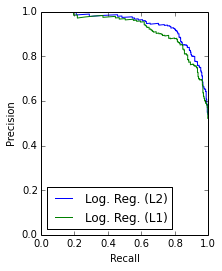

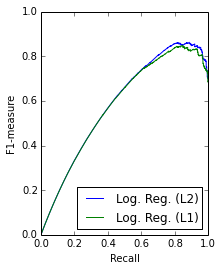

( Log. Reg. (L2) ) AUC =  0.931306706992
( Log. Reg. (L1) ) AUC =  0.91215975805


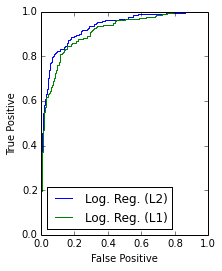

In [9]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
logreg_counts_l2_predicted, log_counts_model = logistic_reg(X_train, X_test, Y_train)
logreg_counts_l1_predicted, _ = logistic_reg(X_train, X_test, Y_train, penalty='l1')

plot.figure(figsize=(3,4))
rp_curve(Y_test, logreg_counts_l2_predicted, label='Log. Reg. (L2)')
rp_curve(Y_test, logreg_counts_l1_predicted, label='Log. Reg. (L1)')
plot.show()
plot.figure(figsize=(3,4))
f1_curve(Y_test, logreg_counts_l2_predicted, label='Log. Reg. (L2)')
f1_curve(Y_test, logreg_counts_l1_predicted, label='Log. Reg. (L1)')
plot.show()
plot.figure(figsize=(3,4))
roc_curve(Y_test, logreg_counts_l2_predicted, label='Log. Reg. (L2)')
roc_curve(Y_test, logreg_counts_l1_predicted, label='Log. Reg. (L1)')

# Подбор коэффициента C для L1- и L2-рег. лог рег

In [14]:
c = [2**(x/10.0) for x in xrange(-100, 150, 1)]

X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
tree_grid_searcher = GridSearchCV(
    estimator=LogisticRegression(), 
    param_grid={
        'C': c,
        'penalty': ['l1', 'l2']
    }, 
    scoring='roc_auc', cv=10, n_jobs=8).fit(X_train, Y_train)
report_cross_validation(tree_grid_searcher, X_test, Y_test)

another method max auc = 0.89674370238 with c =  0.0291572809855 2^ -5.1


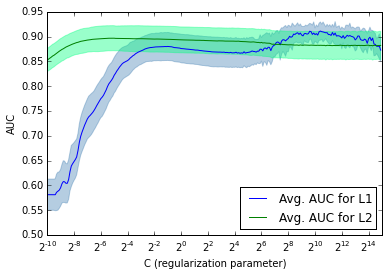

In [29]:
l1_mean = numpy.array([x.mean_validation_score for x in tree_grid_searcher.grid_scores_ if x.parameters['penalty'] == 'l1'])
l2_mean = numpy.array([x.mean_validation_score for x in tree_grid_searcher.grid_scores_ if x.parameters['penalty'] == 'l2'])
l1_std = numpy.array([x.cv_validation_scores.std() for x in tree_grid_searcher.grid_scores_ if x.parameters['penalty'] == 'l1'])
l2_std = numpy.array([x.cv_validation_scores.std() for x in tree_grid_searcher.grid_scores_ if x.parameters['penalty'] == 'l2'])
print "another method max auc =", l2_mean.max(), "with c = ", c[numpy.where(l2_mean==l2_mean.max())[0][0]], "2^", math.log(c[numpy.where(l2_mean==l2_mean.max())[0][0]], 2)
plot.fill_between(c, l1_mean - l1_std, l1_mean + l1_std, color = 'steelblue', alpha = .4)
plot.plot(c, l1_mean, label='Avg. AUC for L1')
plot.xscale('log', basex=2); plot.legend(loc=4);
plot.xlabel('C (regularization parameter)'); plot.ylabel('AUC'); 
plot.fill_between(c, l2_mean - l2_std, l2_mean + l2_std, color = 'springgreen', alpha = .4)
plot.plot(c, l2_mean, label='Avg. AUC for L2')
plot.xscale('log', basex=2); plot.legend(loc=4);
plot.xlabel('C (regularization parameter)'); plot.ylabel('AUC'); 

# Выбор наиболее частотных признаков

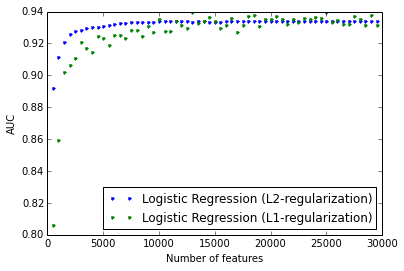

In [11]:
auc_map = {}
for i in xrange(500,30000,500):
    count_vect_top_temp = CountVectorizer(max_features=i)
    matrix_counts_top_temp = count_vect_top_temp.fit_transform(all_texts).toarray()
    X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_top_temp, target)
    logreg_count_top_temp_predicted, _ = logistic_reg(X_train, X_test, Y_train, penalty='l1', C=1024)
    auc_map[i] = get_auc(Y_test, logreg_count_top_temp_predicted)
    
auc_map2 = {}
for i in xrange(500,30000,500):
    count_vect_top_temp = CountVectorizer(max_features=i)
    matrix_counts_top_temp = count_vect_top_temp.fit_transform(all_texts).toarray()
    X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_top_temp, target)
    logreg_count_top_temp_predicted, _ = logistic_reg(X_train, X_test, Y_train, C=0.02915728098552524)
    auc_map2[i] = get_auc(Y_test, logreg_count_top_temp_predicted)
    
plot.plot(auc_map2.keys(), auc_map2.values(), '.', label='Logistic Regression (L2-regularization)')
plot.plot(auc_map.keys(), auc_map.values(), '.', label='Logistic Regression (L1-regularization)')
plot.xlabel('Number of features'); plot.ylabel('AUC'); 
plot.legend(loc=0);

# Изменение способа вычисления признаков (bin, log, tf-idf)

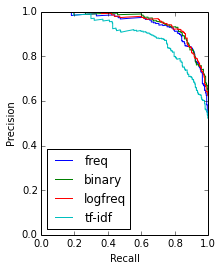

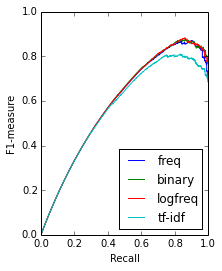

( freq ) AUC =  0.933953033268
( binary ) AUC =  0.945350026686
( logfreq ) AUC =  0.943871197296
( tf-idf ) AUC =  0.876278687066


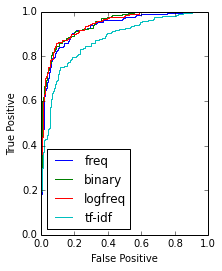

In [12]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
logreg_counts_l2_predicted, _ = logistic_reg(X_train, X_test, Y_train, C=0.02915728098552524)

def bin_f(x):
    return 1 if x > 0 else 0
n_vec_bin = numpy.vectorize(bin_f)
matrix_counts_bin = n_vec_bin(matrix_counts)
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_bin, target)
binreg_bincounts_l2_predicted, _ = logistic_reg(X_train, X_test, Y_train, C=0.02915728098552524)

def log_f(x):
    return math.log(x+1)
n_vec_log = numpy.vectorize(log_f)
matrix_counts_log = n_vec_log(matrix_counts)
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_log, target)
logreg_logcounts_l2_predicted, _ = logistic_reg(X_train, X_test, Y_train, C=0.02915728098552524)

tfidf_transformer = TfidfTransformer()
matrix_tfidf = tfidf_transformer.fit_transform(temp_matrix).toarray()
X_train, X_test, Y_train, Y_test = cross_valid(matrix_tfidf, target)
logreg_counts_l2_predicted_tfidf, _ = logistic_reg(X_train, X_test, Y_train, C=0.02915728098552524)

plot.figure(figsize=(3,4))
rp_curve(Y_test, logreg_counts_l2_predicted, label='freq')
rp_curve(Y_test, binreg_bincounts_l2_predicted, label='binary')
rp_curve(Y_test, logreg_logcounts_l2_predicted, label='logfreq')
rp_curve(Y_test, logreg_counts_l2_predicted_tfidf, label='tf-idf')
plot.show()
plot.figure(figsize=(3,4))
f1_curve(Y_test, logreg_counts_l2_predicted, label='freq')
f1_curve(Y_test, binreg_bincounts_l2_predicted, label='binary')
f1_curve(Y_test, logreg_logcounts_l2_predicted, label='logfreq')
f1_curve(Y_test, logreg_counts_l2_predicted_tfidf, label='tf-idf')
plot.show()
plot.figure(figsize=(3,4))
roc_curve(Y_test, logreg_counts_l2_predicted, label='freq')
roc_curve(Y_test, binreg_bincounts_l2_predicted, label='binary')
roc_curve(Y_test, logreg_logcounts_l2_predicted, label='logfreq')
roc_curve(Y_test, logreg_counts_l2_predicted_tfidf, label='tf-idf')

# Стемминг и удаление стоп-слов

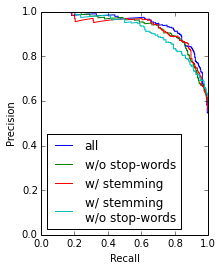

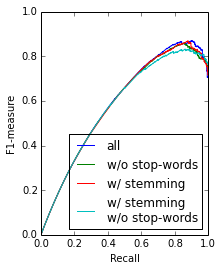

( all ) AUC =  0.933953033268
( w/o stop-words ) AUC =  0.920988258317
( w/ stemming ) AUC =  0.922967443515
( w/ stemming
w/o stop-words ) AUC =  0.909168742217


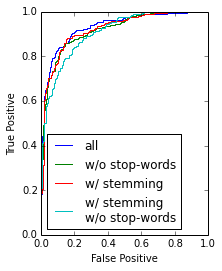

In [13]:
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import string
stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [i for i in tokens if i not in string.punctuation]
    stems = stem_tokens(tokens, stemmer)
    return stems


count_vect_without_stopwords = CountVectorizer(stop_words='english')
matrix_counts_without_stopwords = count_vect_without_stopwords.fit_transform(all_texts).toarray()

count_vect_with_lemm = CountVectorizer(tokenizer=tokenize)
matrix_counts_with_lemm = count_vect_with_lemm.fit_transform(all_texts).toarray()

count_vect_with_lemm_without_stopwords = CountVectorizer(stop_words='english', tokenizer=tokenize)
matrix_counts_with_lemm_without_stopwords = count_vect_with_lemm_without_stopwords.fit_transform(all_texts).toarray()


X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
logreg_counts_l2_predicted, _ = logistic_reg(X_train, X_test, Y_train, C=0.02915728098552524)

X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_without_stopwords, target)
logreg_counts_l2_predicted_without_stopwords, _ = logistic_reg(X_train, X_test, Y_train, C=0.02915728098552524)

X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_with_lemm, target)
logreg_counts_l2_predicted_with_lemm, _ = logistic_reg(X_train, X_test, Y_train, C=0.02915728098552524)

X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_with_lemm_without_stopwords, target)
logreg_counts_l2_predicted_with_lemm_without_stopwords, _ = logistic_reg(X_train, X_test, Y_train, C=0.02915728098552524)

plot.figure(figsize=(3,4))
rp_curve(Y_test, logreg_counts_l2_predicted, label='all')
rp_curve(Y_test, logreg_counts_l2_predicted_without_stopwords, label='w/o stop-words')
rp_curve(Y_test, logreg_counts_l2_predicted_with_lemm, label='w/ stemming')
rp_curve(Y_test, logreg_counts_l2_predicted_with_lemm_without_stopwords, label='w/ stemming\nw/o stop-words')
plot.show()
plot.figure(figsize=(3,4))
f1_curve(Y_test, logreg_counts_l2_predicted, label='all')
f1_curve(Y_test, logreg_counts_l2_predicted_without_stopwords, label='w/o stop-words')
f1_curve(Y_test, logreg_counts_l2_predicted_with_lemm, label='w/ stemming')
f1_curve(Y_test, logreg_counts_l2_predicted_with_lemm_without_stopwords, label='w/ stemming\nw/o stop-words')
plot.show()
plot.figure(figsize=(3,4))
roc_curve(Y_test, logreg_counts_l2_predicted, label='all')
roc_curve(Y_test, logreg_counts_l2_predicted_without_stopwords, label='w/o stop-words')
roc_curve(Y_test, logreg_counts_l2_predicted_with_lemm, label='w/ stemming')
roc_curve(Y_test, logreg_counts_l2_predicted_with_lemm_without_stopwords, label='w/ stemming\nw/o stop-words')

# Выбор наиболее значимых признаков по результатам обучения логистической регрессии

In [17]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
logreg_counts_l2_predicted, log_counts_model = logistic_reg(X_train, X_test, Y_train, C=0.02915728098552524)

## Для самых 5000 значимых


TOP 10 pos
fun, = 0.22772
great, = 0.20050
well, = 0.17918
american, = 0.15442
jackie, = 0.14424
job, = 0.13945
movies, = 0.13638
excellent, = 0.13114
mulan, = 0.13064
memorable, = 0.12936

TOP 10 neg
bad, = -0.34578
worst, = -0.23972
unfortunately, = -0.22826
plot, = -0.20347
only, = -0.20172
nothing, = -0.19425
script, = -0.18455
boring, = -0.16792
director, = -0.15444
have, = -0.15028


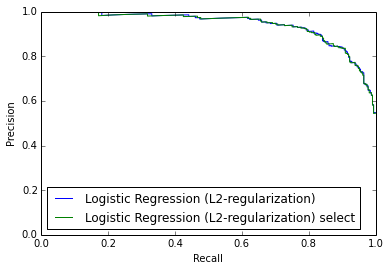

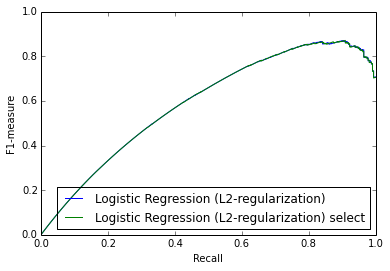

( Logistic Regression (L2-regularization) ) AUC =  0.933953033268
( Logistic Regression (L2-regularization) select ) AUC =  0.93339708237


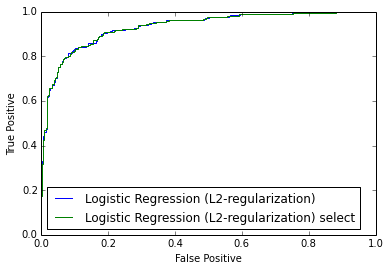

In [18]:
pos_select_by_lr = numpy.argsort(log_counts_model.coef_)[0][::-1][:5000]
neg_select_by_lr = numpy.argsort(log_counts_model.coef_)[0][:5000]

print '\n', 'TOP 10 pos'
for idx in numpy.argsort(log_counts_model.coef_)[0][::-1][:10]: # последние 10 с максимальным коэфициентом
    print '{}, = {:.5f}'.format(words_as_features.get(idx), log_counts_model.coef_[0][idx])
print '\n', 'TOP 10 neg'
for idx in numpy.argsort(log_counts_model.coef_)[0][:10]: # последние 10 с минимальным коэфициентом
    print '{}, = {:.5f}'.format(words_as_features.get(idx), log_counts_model.coef_[0][idx])

select_matrix_counts = (matrix_counts.transpose()[list(set(pos_select_by_lr) | set(neg_select_by_lr))]).transpose()
X_train, X_test, Y_train, Y_test = cross_valid(select_matrix_counts, target)
logreg_counts_l2_select_predicted, _ = logistic_reg(X_train, X_test, Y_train, C=0.02915728098552524)

rp_curve(Y_test, logreg_counts_l2_predicted, label='Logistic Regression (L2-regularization)')
rp_curve(Y_test, logreg_counts_l2_select_predicted, label='Logistic Regression (L2-regularization) select')
plot.show()
f1_curve(Y_test, logreg_counts_l2_predicted, label='Logistic Regression (L2-regularization)')
f1_curve(Y_test, logreg_counts_l2_select_predicted, label='Logistic Regression (L2-regularization) select')
plot.show()
roc_curve(Y_test, logreg_counts_l2_predicted, label='Logistic Regression (L2-regularization)')
roc_curve(Y_test, logreg_counts_l2_select_predicted, label='Logistic Regression (L2-regularization) select')

## AUC в зависимости от количества самых значимых признаков

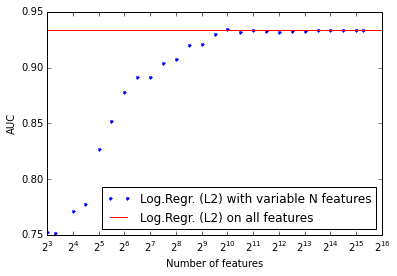

In [19]:
ga =  get_auc(Y_test, logreg_counts_l2_predicted), 
auc_map = {}
for i in [2**(i/2.0) for i in xrange(4,30,1)]:
    pos_select_by_lr = numpy.argsort(log_counts_model.coef_)[0][::-1][:i]
    neg_select_by_lr = numpy.argsort(log_counts_model.coef_)[0][:i]
    l_f = list(set(pos_select_by_lr) | set(neg_select_by_lr))
    n_f = len(l_f)
    select_matrix_counts = (matrix_counts.transpose()[l_f]).transpose()
    X_train, X_test, Y_train, Y_test = cross_valid(select_matrix_counts, target)
    logreg_counts_l2_select_predicted, _ = logistic_reg(X_train, X_test, Y_train, C=0.02915728098552524)
    auc_map[n_f] = get_auc(Y_test, logreg_counts_l2_select_predicted)

plot.plot(auc_map.keys(), auc_map.values(), '.', label='Log.Regr. (L2) with variable N features')
plot.axhline(y=ga,xmin=0,xmax=20000,color='red', label='Log.Regr. (L2) on all features')
plot.xlabel('Number of features'); plot.ylabel('AUC'); 
plot.legend(loc=0); plot.xscale('log', basex=2);

In [23]:
print "Для всех признаков AUC = " + str(ga[0]) + "\n"
print "Максимальное AUC = " + str(max(auc_map.values()))
print "при количестве фич = " + str(auc_map.keys()[auc_map.values().index(max(auc_map.values()))])

Для всех признаков AUC = 0.933953033268

Максимальное AUC = 0.93416429461
при количестве фич = 1024


# Биграммы и триграммы

##Подсчет биграмм

In [10]:
count_vect_with2gramm = CountVectorizer(ngram_range=(1, 2))
matrix_counts_bigram = count_vect_with2gramm.fit_transform(all_texts).toarray()
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_bigram, target)
logreg_counts_2gramm, log_counts_model_2gramm = logistic_reg(X_train, X_test, Y_train, C=0.02915728098552524)

In [11]:
matrix_counts_bigram.shape

(2000, 538909)

##Подсчет триграмм

In [12]:
count_vect_with3gramm = CountVectorizer(ngram_range=(1, 3), max_features=700000)
matrix_counts_3gram = count_vect_with3gramm.fit_transform(all_texts).toarray()
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts_3gram, target)
logreg_counts_3gramm, log_counts_model_3gramm = logistic_reg(X_train, X_test, Y_train, C=0.02915728098552524)

In [13]:
matrix_counts_3gram.shape

(2000, 700000)

## Сравнение с обычной лог рег при всех признаках

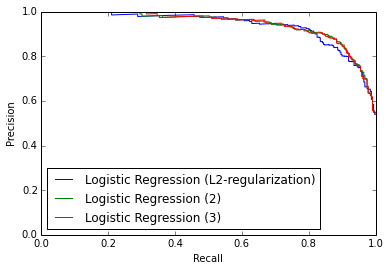

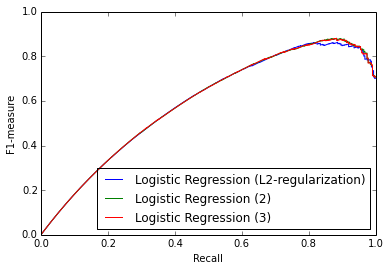

( Logistic Regression (L2-regularization) ) AUC =  0.931306706992
( Logistic Regression (2) ) AUC =  0.936688311688
( Logistic Regression (3) ) AUC =  0.936010051592


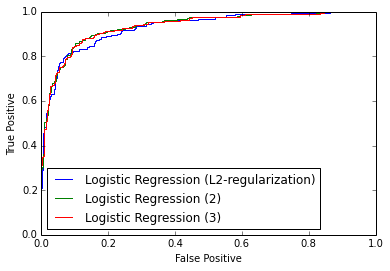

In [14]:
rp_curve(Y_test, logreg_counts_l2_predicted, label='Logistic Regression (L2-regularization)')
rp_curve(Y_test, logreg_counts_2gramm, label='Logistic Regression (2)')
rp_curve(Y_test, logreg_counts_3gramm, label='Logistic Regression (3)')
plot.show()
f1_curve(Y_test, logreg_counts_l2_predicted, label='Logistic Regression (L2-regularization)')
f1_curve(Y_test, logreg_counts_2gramm, label='Logistic Regression (2)')
f1_curve(Y_test, logreg_counts_3gramm, label='Logistic Regression (3)')
plot.show()
roc_curve(Y_test, logreg_counts_l2_predicted, label='Logistic Regression (L2-regularization)')
roc_curve(Y_test, logreg_counts_2gramm, label='Logistic Regression (2)')
roc_curve(Y_test, logreg_counts_3gramm, label='Logistic Regression (3)')

## Уменьшение пристранства у биграмм

In [35]:
auc_map = {}
for i in [2**(i/2.0) for i in xrange(4,30,1)]:
    pos_select_by_lr = numpy.argsort(log_counts_model_2gramm.coef_)[0][::-1][:i]
    neg_select_by_lr = numpy.argsort(log_counts_model_2gramm.coef_)[0][:i]
    l_f = list(set(pos_select_by_lr) | set(neg_select_by_lr))
    n_f = len(l_f)
    select_matrix_counts = (matrix_counts_bigram.transpose()[l_f]).transpose()
    X_train, X_test, Y_train, Y_test = cross_valid(select_matrix_counts, target)
    logreg_counts_l2_select_predicted, _ = logistic_reg(X_train, X_test, Y_train, C=0.02915728098552524)
    auc_map[n_f] = get_auc(Y_test, logreg_counts_l2_select_predicted)

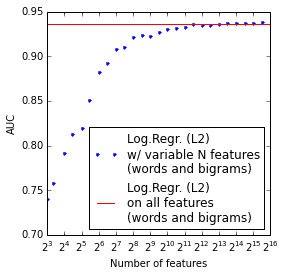

In [36]:
plot.figure(figsize=(4,4))
plot.plot(auc_map.keys(), auc_map.values(), '.', label='Log.Regr. (L2)\nw/ variable N features\n(words and bigrams)')
plot.xlabel('Number of features'); plot.ylabel('AUC'); 
plot.axhline(y=0.936688311688,xmin=0,xmax=20000,color='red', label='Log.Regr. (L2)\non all features\n(words and bigrams)')
plot.legend(loc=0); plot.xscale('log', basex=2);

In [37]:
print "Bigrams max AUC = " + str(max(auc_map.values()))
print "Number of features = " + str(auc_map.keys()[auc_map.values().index(max(auc_map.values()))])

Bigrams max AUC = 0.938055950898
Number of features = 46340


## Уменьшение пристранства у триграмм

In [38]:
auc_map = {}
for i in [2**(i/2.0) for i in xrange(4,30,1)]:
    pos_select_by_lr = numpy.argsort(log_counts_model_3gramm.coef_)[0][::-1][:i]
    neg_select_by_lr = numpy.argsort(log_counts_model_3gramm.coef_)[0][:i]
    l_f = list(set(pos_select_by_lr) | set(neg_select_by_lr))
    n_f = len(l_f)
    select_matrix_counts = (matrix_counts_3gram.transpose()[l_f]).transpose()
    X_train, X_test, Y_train, Y_test = cross_valid(select_matrix_counts, target)
    logreg_counts_l2_select_predicted, _ = logistic_reg(X_train, X_test, Y_train, C=0.02915728098552524)
    auc_map[n_f] = get_auc(Y_test, logreg_counts_l2_select_predicted)

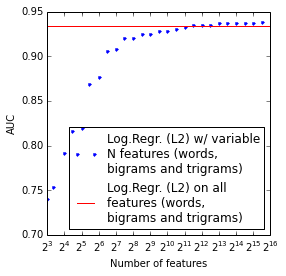

In [39]:
plot.figure(figsize=(4,4))
plot.plot(auc_map.keys(), auc_map.values(), '.', label='Log.Regr. (L2) w/ variable\nN features (words,\nbigrams and trigrams)')
plot.xlabel('Number of features'); plot.ylabel('AUC'); 
plot.axhline(y=0.934464508095,xmin=0,xmax=20000,color='red', label='Log.Regr. (L2) on all\nfeatures (words,\nbigrams and trigrams)')
plot.legend(loc=0); plot.xscale('log', basex=2);

In [40]:
print "Trigrams max AUC = " + str(max(auc_map.values()))
print "Number of features = " + str(auc_map.keys()[auc_map.values().index(max(auc_map.values()))])

Trigrams max AUC = 0.938022593845
Number of features = 46340


# Другие методы ML

## Decision Tree

In [10]:
from sklearn.tree import DecisionTreeClassifier
c_range = range(1,11,1) #range(1,21,1) - original
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
tree_grid_searcher = GridSearchCV(
    estimator=DecisionTreeClassifier(), 
    param_grid={
        'criterion': ['gini'],
        'max_depth': c_range
    }, 
    scoring='roc_auc', cv=10, n_jobs=8).fit(X_train, Y_train)
report_cross_validation(tree_grid_searcher, X_test, Y_test)

train score is 0.68198
test score is 0.66167
best parameter set:
 * criterion=gini
 * max_depth=3


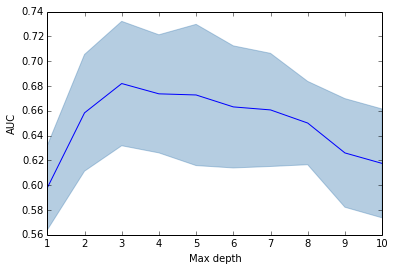

In [ ]:
l1_mean = numpy.array([x.mean_validation_score for x in tree_grid_searcher.grid_scores_])
l1_std = numpy.array([x.cv_validation_scores.std() for x in tree_grid_searcher.grid_scores_])
plot.fill_between(c_range, l1_mean - l1_std, l1_mean + l1_std, color = 'steelblue', alpha = .4)
plot.plot(c_range, l1_mean, label='Avg. AUC for Decision Tree')
plot.xlabel('Max depth'); plot.ylabel('AUC'); 

## Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier
# n_estimators_range = range(1, 1000, 100) + range(1000, 10000, 500) + range(10000, 50000, 2000)
n_estimators_range = range(1, 301, 100)
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
tree_grid_searcher = GridSearchCV(
    estimator=RandomForestClassifier(), 
    param_grid={
        'n_estimators': n_estimators_range
    }, 
    scoring='roc_auc', cv=10, n_jobs=8).fit(X_train, Y_train)
report_cross_validation(tree_grid_searcher, X_test, Y_test)

train score is 0.89337
test score is 0.83833
best parameter set:
 * n_estimators=201


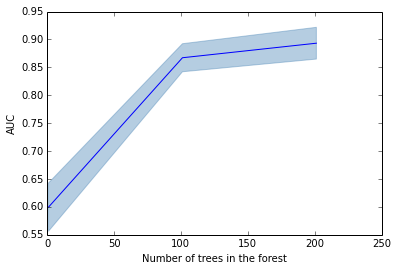

In [71]:
c = range(1, 301, 100)#[10,100,500,1000,2000]
l1_mean = numpy.array([x.mean_validation_score for x in tree_grid_searcher.grid_scores_])
l1_std = numpy.array([x.cv_validation_scores.std() for x in tree_grid_searcher.grid_scores_])
plot.fill_between(c, l1_mean - l1_std, l1_mean + l1_std, color = 'steelblue', alpha = .4)
plot.plot(c, l1_mean, label='Avg. AUC for Random Forest')
plot.xlabel('Number of trees in the forest'); plot.ylabel('AUC'); 

## SVM

In [ ]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
tree_grid_searcher = GridSearchCV(
    estimator=svm.SVC(), 
    param_grid={
        'C': [1,50,200]#[1,2,5,10,15,20,30,40,50,75,100,150,200]
    }, 
    scoring='roc_auc', cv=10, n_jobs=8).fit(X_train, Y_train)
report_cross_validation(tree_grid_searcher, X_test, Y_test)

In [ ]:
c_1 = [1,50,200]#[1,2,5,10,15,20,30,40,50,75,100,150,200]
l1_mean_1 = numpy.array([x.mean_validation_score for x in tree_grid_searcher.grid_scores_])
l1_std_1 = numpy.array([x.cv_validation_scores.std() for x in tree_grid_searcher.grid_scores_])
plot.fill_between(c_1, l1_mean_1 - l1_std_1, l1_mean_1 + l1_std_1, color = 'steelblue', alpha = .4)
plot.plot(c_1, l1_mean_1, label='Avg. AUC for Random Forest')
plot.xlabel('Penalty parameter of the error term'); plot.ylabel('AUC');

## k-ближайших соседей

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
tree_grid_searcher = GridSearchCV(
    estimator=KNeighborsClassifier(), 
    param_grid={
        'n_neighbors': [100, 200, 500]
    }, 
    scoring='roc_auc', cv=2, n_jobs=8).fit(X_train, Y_train)
report_cross_validation(tree_grid_searcher, X_test, Y_test)

In [ ]:
c_k3 = range(1,11,1)+range(20,51,10)+[100, 200, 500]
l1_mean_k_3 = numpy.concatenate((l1_mean_k_2,numpy.array([x.mean_validation_score for x in tree_grid_searcher.grid_scores_])))
l1_std_k_3 = numpy.concatenate((l1_std_k_2,numpy.array([x.cv_validation_scores.std() for x in tree_grid_searcher.grid_scores_])))
plot.fill_between(c_k3, l1_mean_k_3 - l1_std_k_3, l1_mean_k_3 + l1_std_k_3, color = 'steelblue', alpha = .4)
plot.plot(c_k3, l1_mean_k_3, label='Avg. AUC for Random Forest')
plot.xlabel('Number of neighbors'); plot.ylabel('AUC')

# То, что не попало в статью

## Relevance Frequency

In [11]:
def get_after_rf_matrix(in_matrix, target, out_n_features, test_X):
    def bin_f(x):
        return 1 if x > 0 else 0
    n_vec = numpy.vectorize(bin_f)
    in_matrix_bin = n_vec(in_matrix)
    target = numpy.array(target)
    posit_pos = numpy.where(target == 1)[0]
    posit_neg = numpy.where(target == 0)[0]
    pos_rf_prepare = in_matrix_bin[posit_pos].sum(axis=0) 
    neg_rf_prepare = in_matrix_bin[posit_neg].sum(axis=0)
    pos_rf = numpy.array([math.log( 2 + (x / max(1,y)) , 2) for x,y in zip(pos_rf_prepare, neg_rf_prepare)])
    neg_rf = numpy.array([math.log( 2 + (x / max(1,y)) , 2) for x,y in zip(neg_rf_prepare, pos_rf_prepare)])
    l_pos = pos_rf.argsort()[-out_n_features//2:]
    l_neg = neg_rf.argsort()[-out_n_features//2:]
    return ((in_matrix.transpose()[list(set(l_pos) | set(l_neg))]).transpose(),
            (test_X.transpose()[list(set(l_pos) | set(l_neg))]).transpose())

### Сравнение RF и простой логистической регрессией 

#### Для 20000 фич

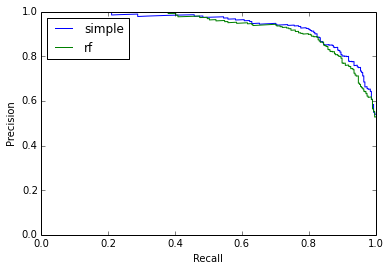

( simple ) AUC =  0.931306706992
( rf ) AUC =  0.919520547945


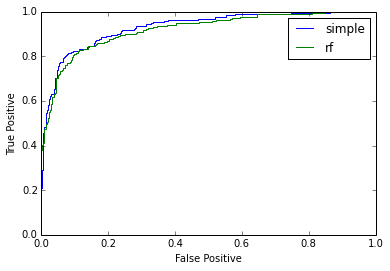

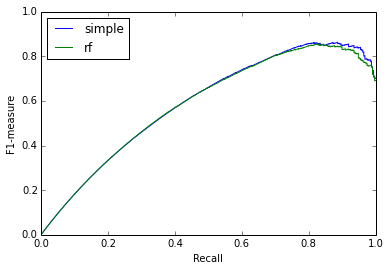

In [16]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
X_train_rf, X_test_rf = get_after_rf_matrix(X_train, Y_train, 20000, X_test)
logreg_rf20000_predicted, _ = logistic_reg(X_train_rf, X_test_rf, Y_train)

rp_curve(Y_test, logreg_counts_l2_predicted, label='simple')
rp_curve(Y_test, logreg_rf20000_predicted, label='rf')
plot.show()
roc_curve(Y_test, logreg_counts_l2_predicted, label='simple')
roc_curve(Y_test, logreg_rf20000_predicted, label='rf')
plot.show()
f1_curve(Y_test, logreg_counts_l2_predicted, label='simple')
f1_curve(Y_test, logreg_rf20000_predicted, label='rf')

#### Зависимость от количества оставляемых фич

In [64]:
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
auc_map = {}
f1_map = {}
for i in xrange(2000,36000,2000):
    print i
    X_train_rf, X_test_rf = get_after_rf_matrix(X_train, Y_train, i, X_test)
    logreg_rf_predicted, _ = logistic_reg(X_train_rf, X_test_rf, Y_train)
    auc_map[i] = get_auc(Y_test, logreg_rf_predicted)

2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000


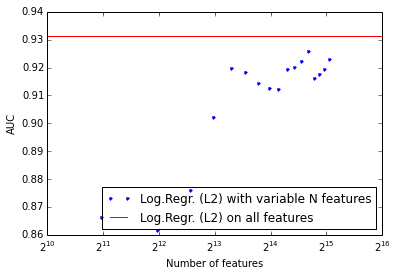

In [65]:
ga =  get_auc(Y_test, logreg_counts_l2_predicted), 
plot.plot(auc_map.keys(), auc_map.values(), '.', label='Log.Regr. (L2) with variable N features')
plot.axhline(y=ga,xmin=0,xmax=30000,color='red', label='Log.Regr. (L2) on all features')
plot.xlabel('Number of features'); plot.ylabel('AUC'); 
plot.legend(loc=0); plot.xscale('log', basex=2);

In [35]:
matrix_counts.shape

(2000, 39659)

## Сравнение лог рег и NBC

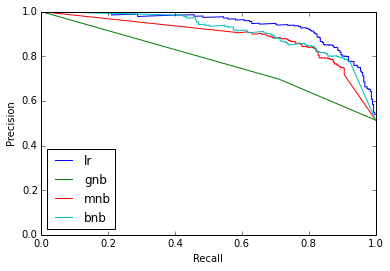

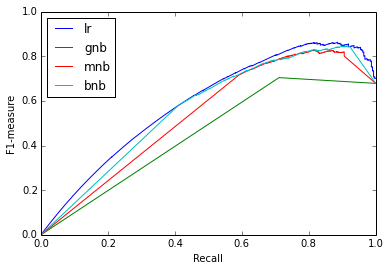

( lr ) AUC =  0.931306706992
( gnb ) AUC =  0.692848247643
( mnb ) AUC =  0.869935287315
( bnb ) AUC =  0.896409669098


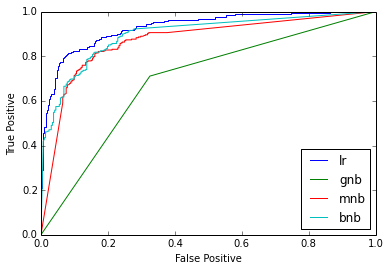

In [66]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()
X_train, X_test, Y_train, Y_test = cross_valid(matrix_counts, target)
gnb.fit(X_train, Y_train)
gnb_predicted = gnb.predict_proba(X_test)
mnb.fit(X_train, Y_train)
mnb_predicted = mnb.predict_proba(X_test)
bnb.fit(X_train, Y_train)
bnb_predicted = bnb.predict_proba(X_test)

rp_curve(Y_test, logreg_counts_l2_predicted, label='lr')
rp_curve(Y_test, gnb_predicted, label='gnb')
rp_curve(Y_test, mnb_predicted, label='mnb')
rp_curve(Y_test, bnb_predicted, label='bnb')
plot.show()
f1_curve(Y_test, logreg_counts_l2_predicted, label='lr')
f1_curve(Y_test, gnb_predicted, label='gnb')
f1_curve(Y_test, mnb_predicted, label='mnb')
f1_curve(Y_test, bnb_predicted, label='bnb')
plot.show()
roc_curve(Y_test, logreg_counts_l2_predicted, label='lr')
roc_curve(Y_test, gnb_predicted, label='gnb')
roc_curve(Y_test, mnb_predicted, label='mnb')
roc_curve(Y_test, bnb_predicted, label='bnb')